In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [2]:
BATCH_SIZE = 32 
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [7]:
import os
print(os.getcwd())


C:\Users\Пользователь\potato-deasese\training


In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../PlantVillage",  
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2153 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 2 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 2 0 0 2 0 0 1 2 1 0 0]


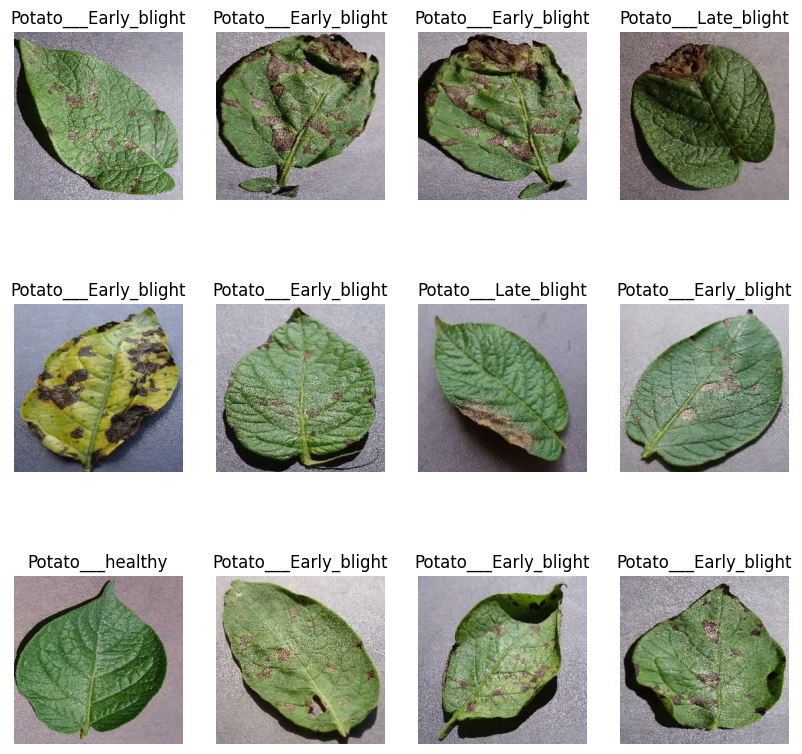

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)

68

In [13]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
test_ds = dataset.skip(54)
len(test_ds)


14

In [16]:
val_size=0.1
len(dataset)*val_size


6.800000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)
len(val_ds)
len(test_ds)

8

In [22]:
len(train_ds)

54

In [23]:
len(val_ds)

6

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


In [28]:
from tensorflow.keras import layers
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])


In [29]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [31]:
from tensorflow.keras import layers, models

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # без BATCH_SIZE
n_classes = 3

model = models.Sequential([
    layers.Input(shape=input_shape),  # задаём форму входа
    resize_and_rescale,
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [32]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,742,979 (14.28 MB)

 Trainable params: 3,742,979 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 322ms/step - accuracy: 0.6400 - loss: 0.7754 - val_accuracy: 0.8438 - val_loss: 0.4528
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 312ms/step - accuracy: 0.8507 - loss: 0.3752 - val_accuracy: 0.8906 - val_loss: 0.2661
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 311ms/step - accuracy: 0.8733 - loss: 0.2827 - val_accuracy: 0.8177 - val_loss: 0.3739
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 309ms/step - accuracy: 0.8970 - loss: 0.2579 - val_accuracy: 0.8854 - val_loss: 0.2593
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 315ms/step - accuracy: 0.9381 - loss: 0.1569 - val_accuracy: 0.9688 - val_loss: 0.1033
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 311ms/step - accuracy: 0.9398 - loss: 0.1721 - val_accuracy: 0.9688 - val_loss: 0.1040
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 307ms/step - accuracy: 0.9566 - loss: 0.1111 - val_accuracy: 0.9688 - val_loss: 0.0822
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 307ms/step - accuracy: 0.9485 - loss: 0.1351 - val_accu

In [35]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9609 - loss: 0.0654


In [36]:
scores

[0.06542772054672241, 0.9609375]

In [37]:
history

In [38]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [39]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [40]:
type(history.history['loss'])

list

In [41]:
len(history.history['loss'])

50

In [42]:
history.history['loss'][:5]

[0.7754029035568237,
 0.37515005469322205,
 0.28270477056503296,
 0.25785404443740845,
 0.15685507655143738]

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

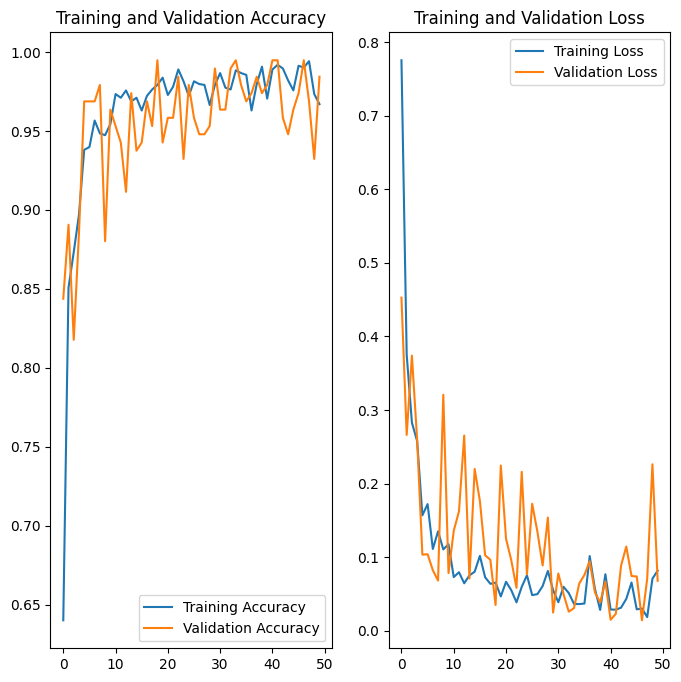

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
predicted label: Potato___Late_blight


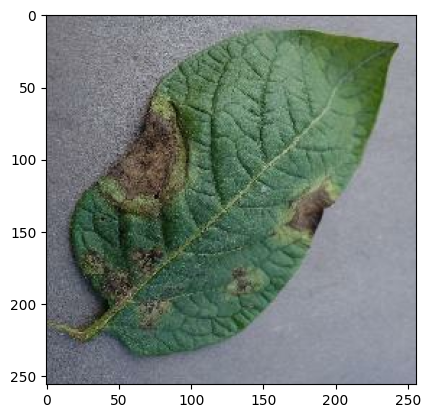

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


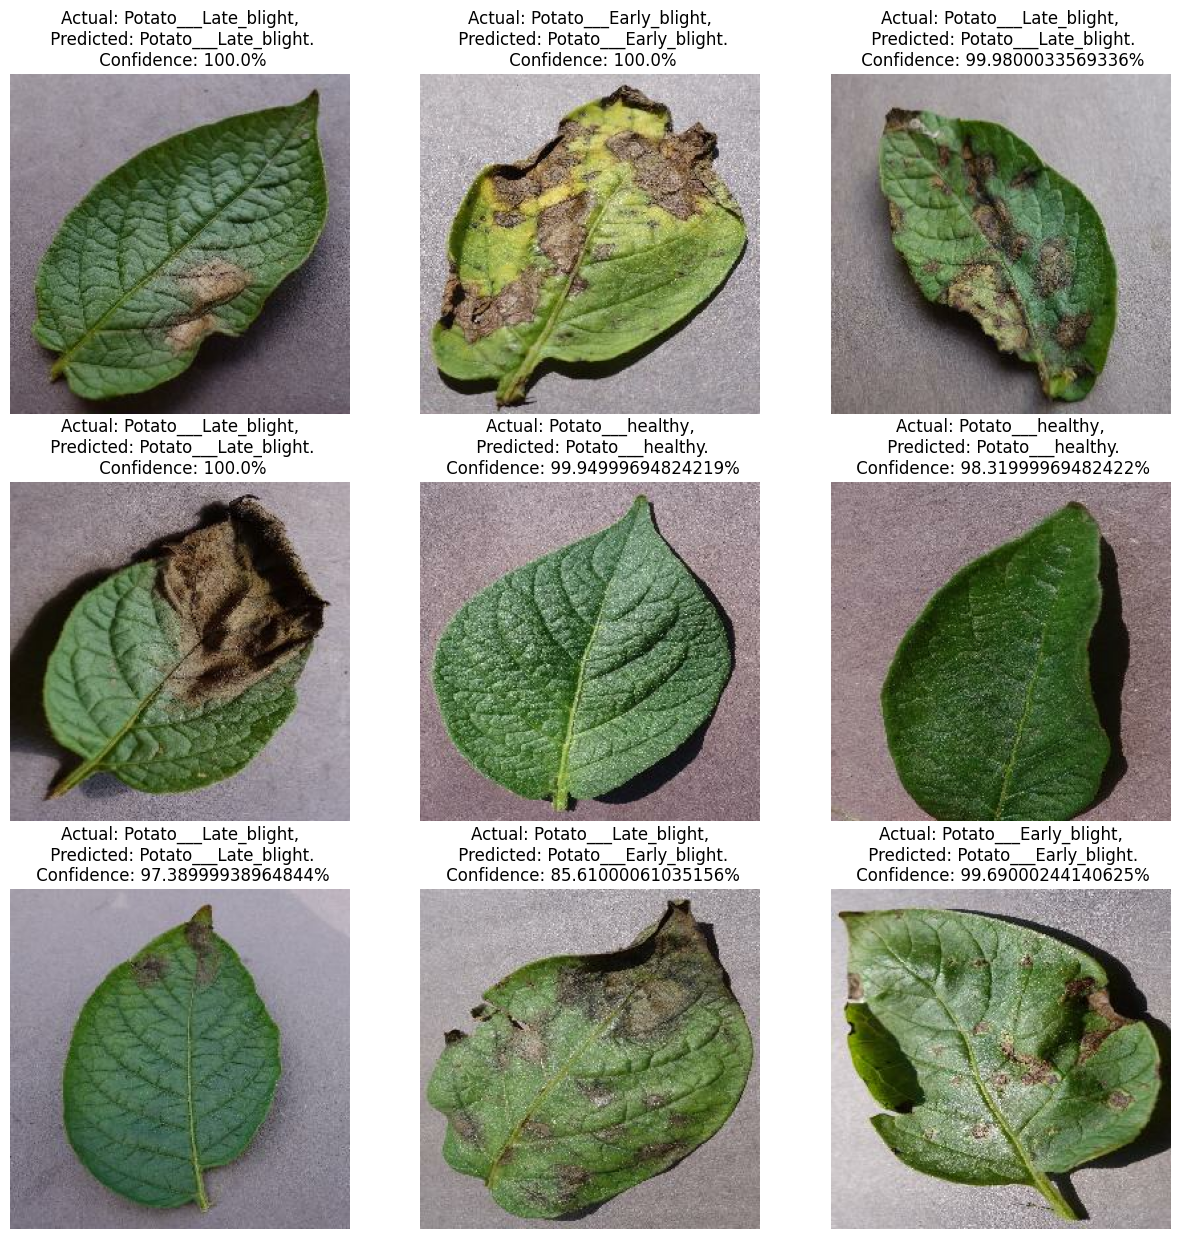

In [47]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [51]:
import os

path = "../models"
os.makedirs(path, exist_ok=True)

# определяем версию модели
existing = [int(i.split('.')[0]) for i in os.listdir(path) if i.split('.')[0].isdigit()]
model_version = max(existing + [0]) + 1

# сохраняем модель
save_path = f"{path}/{model_version}.keras"  # можно заменить на .h5
model.save(save_path)

print(f"Модель сохранена: {save_path}")


Модель сохранена: ../models/1.keras


In [52]:
save_path = f"{path}/{model_version}.h5"
model.save(save_path)


In [53]:
from tensorflow import keras

latest_model = keras.models.load_model("../models/1.keras")


In [54]:
model.save("../potatoes.h5")

In [55]:
model.save("my_model.keras")


In [56]:
model.save("model.keras")
